# Introduction

This notebook is a 'quick-start' for the [CGIAR Crop Yield Prediction Challenge](https://zindi.africa/competitions/cgiar-crop-yield-prediction-challenge). We'll take a look at the data, fit a quick model and make a submission, with hints at each stage for extra options to investigate.

Let's dive in!

# Setup

You can get the zip files from Zindi or add to your Google drive using the following links:

Test data: https://drive.google.com/file/d/1yTEgzn8JJn0mZmJ7NDUbwAB1WSzwRScB/view?usp=sharing

Training data: 
https://drive.google.com/file/d/1-0UNiBpvfdRq8rgUC3Kb22YPWP_YnoKj/view?usp=sharing

You'll also need the smaller files from Zindi (Train.csv, SampleSubmission.csv and bandnames.txt) which you can just upload using the files tab.

In [ ]:
import pandas as pd, numpy as np, warnings, tensorflow as tf, os, seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from tensorflow.keras import layers
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

In [ ]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive # Link your drive if you are a colab user
drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Change the directory to the Dataset directory
%cd /content/gdrive/MyDrive/CGIAR_Yield_Estimation_dataset/

/content/gdrive/MyDrive/CGIAR_Yield_Estimation_dataset


In [ ]:
# # Extract - image_arrays_train and test
import zipfile
with zipfile.ZipFile('./image_arrays_train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/gdrive/MyDrive/CGIAR_Yield_Estimation_dataset/image_arrays_train')
    zip_ref.extractall('/content/gdrive/MyDrive/CGIAR_Yield_Estimation_dataset/image_arrays_test')


In [ ]:
# from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#     rescale=1./255,  # rescale pixel values to [0,1]
#     rotation_range=40,  # random rotation up to 40 degrees
#     width_shift_range=0.2,  # random horizontal shift
#     height_shift_range=0.2,  # random vertical shift
#     shear_range=0.2,  # random shear transformation
#     zoom_range=0.2,  # random zoom in/out
#     horizontal_flip=True,  # random horizontal flip
#     fill_mode='nearest'  # fill missing pixels with nearest neighbor
# )

# train_generator = datagen.flow_from_directory(
#     '/content/gdrive/MyDrive/CGIAR_Yield_Estimation_dataset/image_arrays_train',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical'
# )

# test_generator = datagen.flow_from_directory(
#     '/content/gdrive/MyDrive/CGIAR_Yield_Estimation_dataset/image_arrays_test',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical'
# )


In [ ]:
# Check the CSV files are present
!ls *.csv # Upload through the files menu

fields_w_additional_info.csv  test_field_ids_with_year.csv
SampleSubmission.csv	      Train.csv


In [ ]:
# Check for bandnames.txt
!ls *.txt

bandnames.txt


# Loading the data

The data isn't a simple table - instead we must read the inputs from individual .npy files. Here we'll load the dataframes, open a file or two and take a look at the format.

In [ ]:
# Train.csv has the Field_IDs needed to find the npy files
train = pd.read_csv('/content/gdrive/MyDrive/CGIAR_Yield_Estimation_dataset/Train.csv')
print(train.shape)
train.head()

(2977, 4)


,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


In [ ]:
# identify how many years data were collected
train.Year.unique()

array([2019, 2018, 2017, 2016])

In [ ]:
# train.info()

Loading /content/gdrive/MyDrive/CGIAR_Yield_Estimation_dataset/image_arrays_train/image_arrays_train/5ZOZ3XU.npy as an array
Array shape: (360, 41, 41)


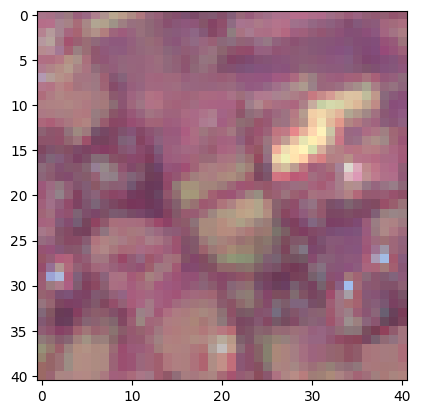

In [ ]:
# Look at a sample:
fid = train['Field_ID'].sample().values[0] 
# File name based on Field_ID
fn = f'/content/gdrive/MyDrive/CGIAR_Yield_Estimation_dataset/image_arrays_train/image_arrays_train/{fid}.npy'
print(f'Loading {fn} as an array')
arr = np.load(fn) # Loading the data with numpy
print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
rgb_jan = np.stack([arr[4], arr[3], arr[2]], axis=-1) # Combine three bands for viewing
rgb_jan = rgb_jan / np.max(rgb_jan) # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_jan) # View with matplotlib

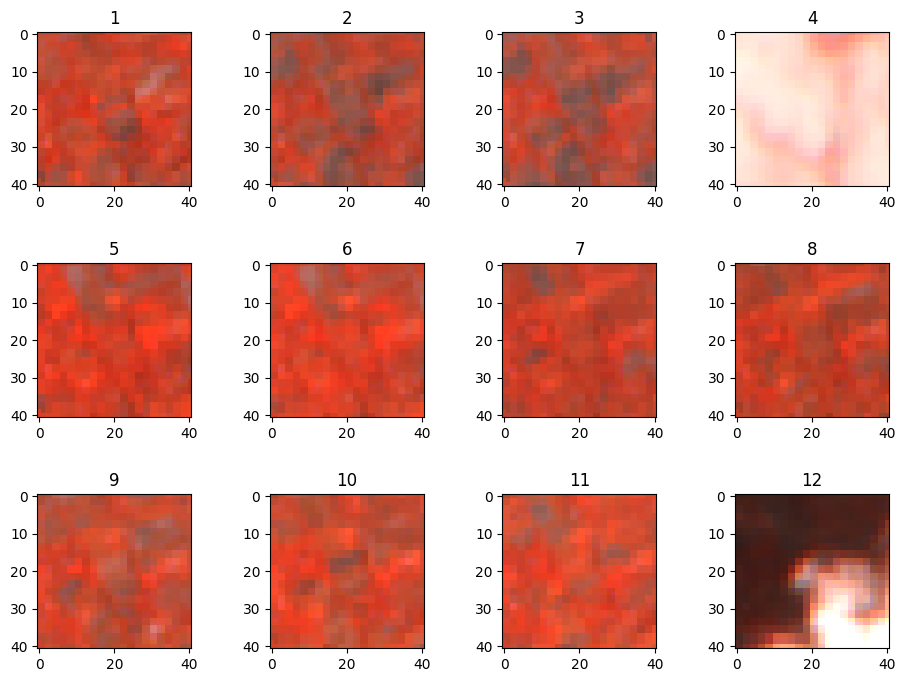

In [ ]:
# View false colour images from each month in the year:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  rgb = np.stack([arr[i*30 + 8], arr[i*30 + 4], arr[i*30 + 3]], axis=-1) # False colour (band 8, 4 and 3)
  rgb = rgb / 4000 # Scaling consistently 
  axs[i].imshow(rgb.clip(0, 1))
  axs[i].set_title(str(i+1))

What's with the white fluffy stuff? These are clouds - the bane of all remote sensing analysts...

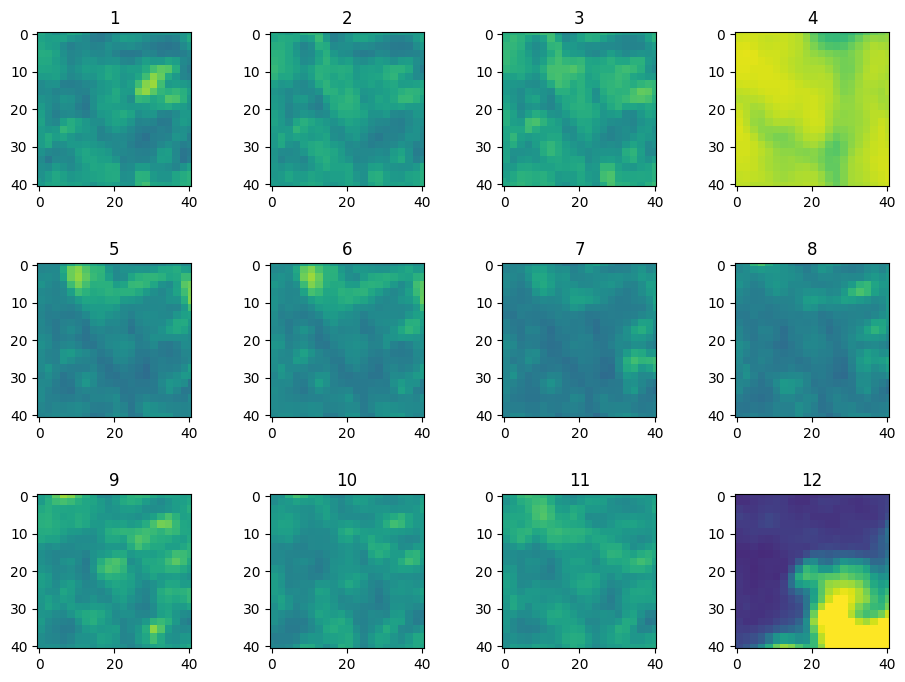

In [ ]:
# Show the SWIR band (B12) where clouds have a high reflectance
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  cloud = arr[i*30 + 11]
  axs[i].imshow(cloud, vmin=0, vmax=4000)
  axs[i].set_title(str(i+1))

# Sampling from the images

There are some hard-coded band indexes in the examples above that won't have made sense - how did we know which bands were which?
There are 30 bands for each month. You can see the full list of bands with:

In [ ]:
band_names = [l.strip() for l in open('/content/gdrive/MyDrive/CGIAR_Yield_Estimation_dataset/bandnames.txt', 'r').readlines()]
print(band_names)

['0_S2_B1', '0_S2_B2', '0_S2_B3', '0_S2_B4', '0_S2_B5', '0_S2_B6', '0_S2_B7', '0_S2_B8', '0_S2_B8A', '0_S2_B9', '0_S2_B10', '0_S2_B11', '0_S2_B12', '0_S2_QA10', '0_S2_QA20', '0_S2_QA60', '0_CLIM_aet', '0_CLIM_def', '0_CLIM_pdsi', '0_CLIM_pet', '0_CLIM_pr', '0_CLIM_ro', '0_CLIM_soil', '0_CLIM_srad', '0_CLIM_swe', '0_CLIM_tmmn', '0_CLIM_tmmx', '0_CLIM_vap', '0_CLIM_vpd', '0_CLIM_vs', '1_S2_B1', '1_S2_B2', '1_S2_B3', '1_S2_B4', '1_S2_B5', '1_S2_B6', '1_S2_B7', '1_S2_B8', '1_S2_B8A', '1_S2_B9', '1_S2_B10', '1_S2_B11', '1_S2_B12', '1_S2_QA10', '1_S2_QA20', '1_S2_QA60', '1_CLIM_aet', '1_CLIM_def', '1_CLIM_pdsi', '1_CLIM_pet', '1_CLIM_pr', '1_CLIM_ro', '1_CLIM_soil', '1_CLIM_srad', '1_CLIM_swe', '1_CLIM_tmmn', '1_CLIM_tmmx', '1_CLIM_vap', '1_CLIM_vpd', '1_CLIM_vs', '2_S2_B1', '2_S2_B2', '2_S2_B3', '2_S2_B4', '2_S2_B5', '2_S2_B6', '2_S2_B7', '2_S2_B8', '2_S2_B8A', '2_S2_B9', '2_S2_B10', '2_S2_B11', '2_S2_B12', '2_S2_QA10', '2_S2_QA20', '2_S2_QA60', '2_CLIM_aet', '2_CLIM_def', '2_CLIM_pdsi', '2

0_S2_B1 is band one from the Sentinel 2 image for January (month 0). They're ordered, so we know that the first image band in the array is 0_S2_B1...

You'll likely want to examine specific bands. Here's an example where we create a function to sample the center point (20, 20) for specified bands from each month:

In [ ]:
def process_im(fid, folder='/content/gdrive/MyDrive/CGIAR_Yield_Estimation_dataset/image_arrays_train/image_arrays_train'):
  fn = f'{folder}/{fid}.npy'
  arr = np.load(fn)
  bands_of_interest = ['S2_B5', 'S2_B4', 'S2_B3', 'S2_B2', 'CLIM_pr', 'CLIM_soil']
  values = {}
  for month in range(12):
    bns = [str(month) + '_' + b for b in bands_of_interest] # Bands of interest for this month 
    idxs = np.where(np.isin(band_names, bns)) # Index of these bands
    vs = arr[idxs, 20, 20] # Sample the im at the center point
    for bn, v in zip(bns, vs[0]):
      values[bn] = v
  return values

# Example
# process_im('35AFSDD')

In [ ]:
# identify size of our bands of 360 and file size of 41 by 41
arr.shape

(360, 41, 41)

With this, we can sample the inputs for each field in train and use that to build a dataframe of input features:

In [ ]:
# Make a new DF with the sampled values from each field 
train_sampled = pd.DataFrame([process_im(fid) for fid in train['Field_ID'].values])

# Add in the field ID and yield
train_sampled['Field_ID'] = train['Field_ID'].values
train_sampled['Yield'] = train['Yield'].values
train_sampled.head()

,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,1_S2_B5,1_S2_B4,1_S2_B3,1_S2_B2,...,10_CLIM_pr,10_CLIM_soil,11_S2_B5,11_S2_B4,11_S2_B3,11_S2_B2,11_CLIM_pr,11_CLIM_soil,Field_ID,Yield
0,934,932,1173,1392,4,287,1015,1036,1397,1516,...,83,93,744,699,393,790,125,215,MH2O0YH,3.686
1,880,821,924,1116,4,287,933,873,1011,1152,...,78,96,703,524,323,420,126,215,O9TURWL,5.657
2,1016,1070,1357,1632,4,278,1108,1193,1588,1947,...,75,93,2935,2961,3598,4145,135,289,35AFSDD,3.082
3,777,784,639,1064,3,299,832,875,823,1237,...,86,95,7289,7389,8025,8057,121,189,PM05EG9,2.707
4,1081,1122,1162,1487,20,427,1046,1063,1133,1454,...,122,1123,1054,1097,789,1349,194,1214,V7PZBCG,2.679


## Concatenating the train samples Dataframe with the corresponding additional field information.

In [254]:
# load the field informations dataset
# fields_additional_info.csv has the additional infomation of the fields 
fields_additional_info= pd.read_csv('/content/gdrive/MyDrive/CGIAR_Yield_Estimation_dataset/fields_w_additional_info.csv')
print(fields_additional_info.shape)
fields_additional_info.head()

(4032, 684)


,Field_ID,soil_bdod_5-15cm_mean,soil_cec_5-15cm_mean,soil_cfvo_5-15cm_mean,soil_clay_5-15cm_mean,soil_nitrogen_5-15cm_mean,soil_ocd_5-15cm_mean,soil_ocs_0-30cm_mean,soil_phh2o_5-15cm_mean,soil_sand_5-15cm_mean,...,climate_2019_12_pr,climate_2019_12_ro,climate_2019_12_soil,climate_2019_12_srad,climate_2019_12_swe,climate_2019_12_tmmn,climate_2019_12_tmmx,climate_2019_12_vap,climate_2019_12_vpd,climate_2019_12_vs
0,MH2O0YH,118.0,257.0,85.0,463.0,2458.0,323.0,57.0,59.0,308.0,...,125.0,6.0,215.0,1880.0,0.0,100.0,267.0,1680.0,69.0,210.0
1,O9TURWL,120.0,288.0,84.0,462.0,2108.0,306.0,58.0,61.0,243.0,...,126.0,6.0,215.0,1883.0,0.0,99.0,273.0,1682.0,75.0,190.0
2,35AFSDD,120.0,263.0,102.0,495.0,1991.0,288.0,58.0,60.0,271.0,...,135.0,7.0,289.0,1875.0,0.0,100.0,274.0,1690.0,76.0,200.0
3,PM05EG9,122.0,206.0,66.0,431.0,2432.0,337.0,65.0,57.0,332.0,...,121.0,6.0,189.0,1898.0,0.0,98.0,263.0,1688.0,64.0,210.0
4,V7PZBCG,124.0,167.0,116.0,439.0,566.0,302.0,53.0,56.0,326.0,...,194.0,66.0,1214.0,1930.0,0.0,143.0,291.0,1972.0,87.0,270.0


In [255]:
# Extracting the field infomation that matches the our train sample fields
train_fields_additional_info = fields_additional_info.iloc[0:train_sampled.shape[0]]

# Place the DataFrames side by side
new_train_sampled = pd.concat([train_sampled, train_fields_additional_info], axis=1)
new_train_sampled.head()

,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,1_S2_B5,1_S2_B4,1_S2_B3,1_S2_B2,...,climate_2019_12_pr,climate_2019_12_ro,climate_2019_12_soil,climate_2019_12_srad,climate_2019_12_swe,climate_2019_12_tmmn,climate_2019_12_tmmx,climate_2019_12_vap,climate_2019_12_vpd,climate_2019_12_vs
0,934,932,1173,1392,4,287,1015,1036,1397,1516,...,125.0,6.0,215.0,1880.0,0.0,100.0,267.0,1680.0,69.0,210.0
1,880,821,924,1116,4,287,933,873,1011,1152,...,126.0,6.0,215.0,1883.0,0.0,99.0,273.0,1682.0,75.0,190.0
2,1016,1070,1357,1632,4,278,1108,1193,1588,1947,...,135.0,7.0,289.0,1875.0,0.0,100.0,274.0,1690.0,76.0,200.0
3,777,784,639,1064,3,299,832,875,823,1237,...,121.0,6.0,189.0,1898.0,0.0,98.0,263.0,1688.0,64.0,210.0
4,1081,1122,1162,1487,20,427,1046,1063,1133,1454,...,194.0,66.0,1214.0,1930.0,0.0,143.0,291.0,1972.0,87.0,270.0


In [256]:
train_sampled.tail()

,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,1_S2_B5,1_S2_B4,1_S2_B3,1_S2_B2,...,10_CLIM_pr,10_CLIM_soil,11_S2_B5,11_S2_B4,11_S2_B3,11_S2_B2,11_CLIM_pr,11_CLIM_soil,Field_ID,Yield
2972,1060,1216,1291,1586,80,562,1167,1322,1626,1865,...,145,139,1138,1344,1691,1896,31,119,FFX8W83,4.662
2973,952,1014,906,1205,73,520,1095,1152,1263,1417,...,142,122,955,1035,931,1290,30,107,JAOFQM9,3.506
2974,894,931,797,1196,79,615,1015,1020,1292,1411,...,141,130,931,995,1005,1423,30,114,Z4D9MU8,2.619
2975,917,987,948,1327,38,450,921,992,897,1339,...,70,225,932,985,1038,1324,12,193,SX57GH1,4.174
2976,1030,1043,1127,1343,74,880,1013,1061,1056,1384,...,112,167,1628,1638,1721,2066,18,146,A69YGTK,3.775


In [257]:
new_train_sampled.tail()

,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,1_S2_B5,1_S2_B4,1_S2_B3,1_S2_B2,...,climate_2019_12_pr,climate_2019_12_ro,climate_2019_12_soil,climate_2019_12_srad,climate_2019_12_swe,climate_2019_12_tmmn,climate_2019_12_tmmx,climate_2019_12_vap,climate_2019_12_vpd,climate_2019_12_vs
2972,1060,1216,1291,1586,80,562,1167,1322,1626,1865,...,171.0,10.0,914.0,2009.0,0.0,150.0,295.0,1864.0,106.0,280.0
2973,952,1014,906,1205,73,520,1095,1152,1263,1417,...,173.0,9.0,751.0,2016.0,0.0,156.0,298.0,1909.0,109.0,280.0
2974,894,931,797,1196,79,615,1015,1020,1292,1411,...,177.0,10.0,969.0,2005.0,0.0,149.0,295.0,1890.0,103.0,290.0
2975,917,987,948,1327,38,450,921,992,897,1339,...,152.0,8.0,507.0,1892.0,0.0,105.0,277.0,1786.0,72.0,150.0
2976,1030,1043,1127,1343,74,880,1013,1061,1056,1384,...,202.0,61.0,1261.0,1915.0,0.0,125.0,282.0,1900.0,75.0,230.0


In [258]:
print("train sample shape =",train_sampled.shape)
print("Addition field info of train sample shape =",train_fields_additional_info.shape)
print("train sample after adding field info shape =",new_train_sampled.shape)

train sample shape = (2977, 74)
Addition field info of train sample shape = (2977, 684)
train sample after adding field info shape = (2977, 758)


# Fitting a model

Now that we have a way to get features from the inputs, we can fit a model and see how it does:

1. With RandomForestRegressor

RMSE Score: 1.539520722675765
R-squared: 0.15855028977221997


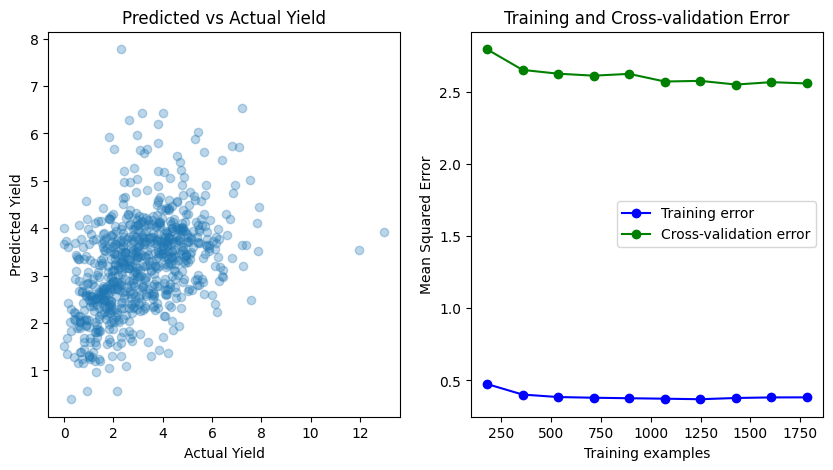

In [201]:
# Split the data
X, y = train_sampled[train_sampled.columns[:-2]], train_sampled['Yield']
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Fit the model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Score with RMSE and R-squared
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print('RMSE Score:', rmse)
print('R-squared:', r2)

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5,
    scoring='neg_mean_squared_error', shuffle=True, random_state=42)

# Plot predicted vs actual for the test set
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, ))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.scatter(y_test, model.predict(X_test), alpha=0.3)
ax1.set_xlabel('Actual Yield')
ax1.set_ylabel('Predicted Yield')
ax1.set_title('Predicted vs Actual Yield')

# Plot training and cross-validation error
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
ax2.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training error')
ax2.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation error')
ax2.set_xlabel('Training examples')
ax2.set_ylabel('Mean Squared Error')
ax2.set_title('Training and Cross-validation Error')
ax2.legend(loc='best')

plt.show()


2. With XGBoost Model

RMSE Score: 1.6493945893329784
R-squared: 0.06653842541913546


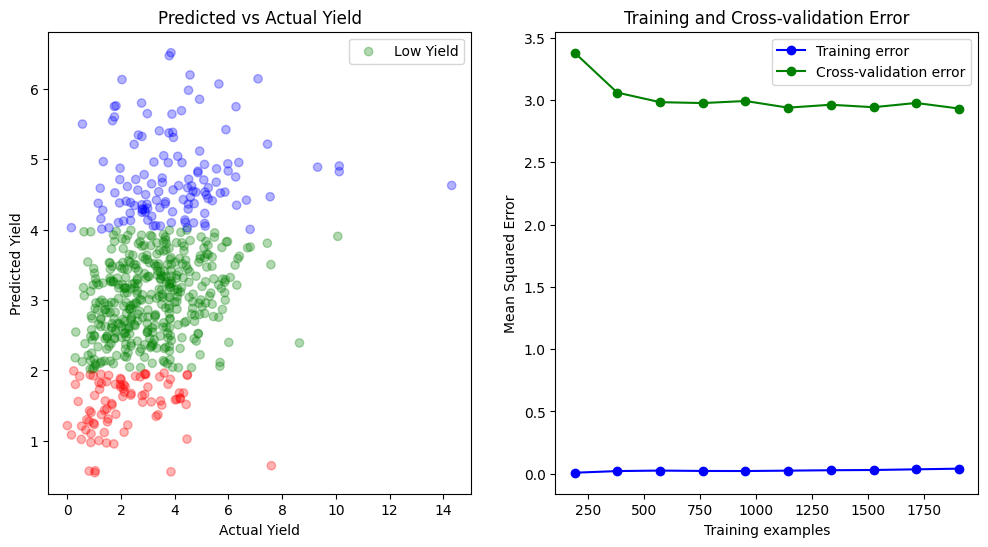

In [202]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = XGBRegressor()
model.fit(X_train, y_train)

# Score with RMSE and R-squared
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print('RMSE Score:', rmse)
print('R-squared:', r2)

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5,
    scoring='neg_mean_squared_error', shuffle=True, random_state=42)

# Get the predicted yield values for the test set
y_pred = model.predict(X_test)

# Assign different colors to different yield prediction values
colors = np.where(y_pred < 2, 'red', 'green')
colors = np.where(y_pred > 4, 'blue', colors)

# Plot predicted vs actual for the test set
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(y_test, y_pred, c=colors, alpha=0.3)
ax1.set_xlabel('Actual Yield')
ax1.set_ylabel('Predicted Yield')
ax1.set_title('Predicted vs Actual Yield')
ax1.legend(['Low Yield', 'High Yield'])

# Plot training and cross-validation error
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
ax2.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training error')
ax2.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation error')
ax2.set_xlabel('Training examples')
ax2.set_ylabel('Mean Squared Error')
ax2.set_title('Training and Cross-validation Error')
ax2.legend(loc='best')
ax2.legend(['Training error', 'Cross-validation error'])


plt.show()


3. Using deep learning of network architecture, such as a multi-layer perceptron (MLP).

19/19 [==============================] - 0s 2ms/step
RMSE Score: 5.550156725838534
R-squared: -9.569581890507886
19/19 [==============================] - 0s 1ms/step


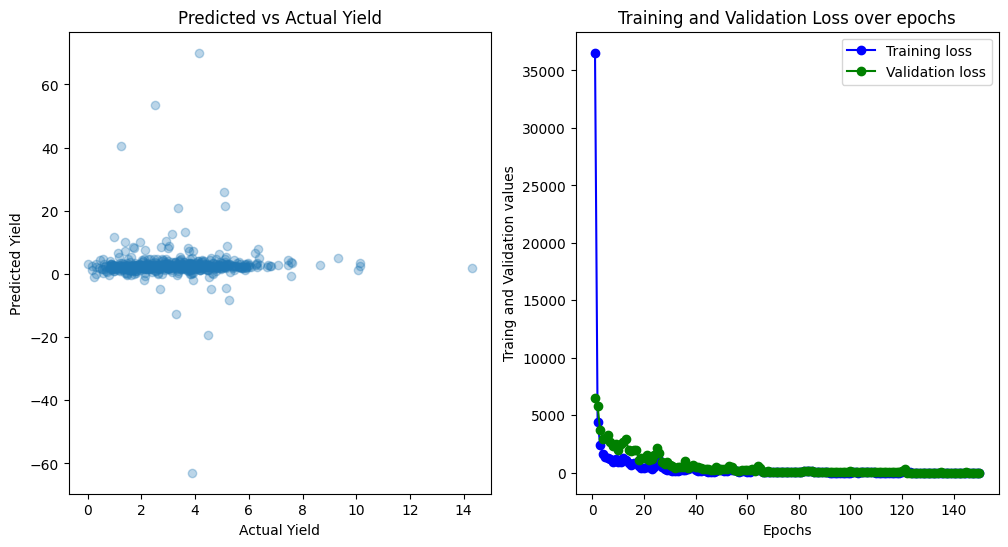

In [203]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Define the MLP architecture
model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Fit the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=150, batch_size=32, verbose=0)

# Score with RMSE and R-squared
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print('RMSE Score:', rmse)
print('R-squared:', r2)

# Plot predicted vs actual for the test set
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(y_test, model.predict(X_test), alpha=0.3)
ax1.set_xlabel('Actual Yield')
ax1.set_ylabel('Predicted Yield')
ax1.set_title('Predicted vs Actual Yield')

# Plot training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
ax2.plot(epochs, train_loss, 'o-', color='blue', label='Training loss')
ax2.plot(epochs, val_loss, 'o-', color='green', label='Validation loss')

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Traing and Validation values')
ax2.set_title('Training and Validation Loss over epochs')
ax2.legend(loc='best')



plt.show()


# Saving Preds

Once we're happy with how we generate our inputs, we must process the test fields in the same way and save predictions. Here it is, condensed. Note the Field_IDs from the sample submission are used, and the same `process_im` function prepares the inputs, this time looking for .npy files in the 'image_arrays_test' folder. 

You can submit the Sub.csv file generated here on Zindi. This example scores ~2 (not as good as our score on our local test set, because the fields are more geographically separated). Now let's chat about ways to make this better:

# Improvements


1.   For the example above I chose the 'bands of interest' fairly randomly. A bit of research into which Sentinel 2 bands are used in this kind of task and what the different climate variables are should help make more informed choices there.
2.   We looked at all 12 months. Maize is normally planted just before the March-May rainy season (I think?) and harvested a few months later. Choose which months you'll prioritise to cut down on less useful data
3.   We looked at only the center pixel. Can you use a wider area to get better features? What about finding which pixels are most likely fields and sampling those?
**4.   We did no model tuning, so obviously lots of fun to be had there**
5.   Low-quality locations are often not fields - leave these out of your training set for better results. There are no low-quality (Quality=1) fields in the test set.
**6.   Common measures such as NDVI, EVI etc can be computed by combining different bands. Look up how these vegetative indices are calculated for sentinel 2 and see if you can add those as features.**
6.   ... As always, be creative - I'm sure there are lots more improvements to be made



Calculate NDVI

In [ ]:
# # Set the directory path
# directory = '/content/gdrive/MyDrive/CGIAR_Yield_Estimation_dataset/image_arrays_test/image_arrays_train/'

# # Create the 'ndvi_calculated' folder inside the directory
# ndvi_dir = os.path.join(directory, 'ndvi_calculated')
# if not os.path.exists(ndvi_dir):
#     os.makedirs(ndvi_dir)

# # Loop through all files in the directory with .npy extension
# for filename in os.listdir(directory):
#     if filename.endswith(".npy"):
#         # Load the image from the file
#         image = np.load(os.path.join(directory, filename))
        
#         # Check that the image array has at least three dimensions
#         if len(image.shape) < 3:
#             continue
        
#         # Determine which channels correspond to NIR and red
#         nir_channel = None
#         red_channel = None
#         for i in range(image.shape[2]):
#             if np.mean(image[:, :, i]) > 0.1:  # This channel is not mostly black
#                 if nir_channel is None:
#                     nir_channel = i
#                 else:
#                     red_channel = i
#                     break
        
#         if nir_channel is None or red_channel is None:
#             # Could not determine NIR and red channels
#             continue
        
#         # Calculate the NDVI
#         nir = image[:, :, nir_channel]
#         red = image[:, :, red_channel]
#         ndvi = (nir - red) / (nir + red)
        
#         # Save the NDVI image as a new .npy file in the 'ndvi_calculated' folder
#         ndvi_filename = os.path.join(ndvi_dir, filename[:-4] + '_ndvi.npy')
#         np.save(ndvi_filename, ndvi)


In [259]:
print(train.columns)

Index(['Field_ID', 'Year', 'Quality', 'Yield'], dtype='object')


In [260]:
train.Field_ID.values

array(['MH2O0YH', 'O9TURWL', '35AFSDD', ..., 'Z4D9MU8', 'SX57GH1',
       'A69YGTK'], dtype=object)

Bar diagram of quality and yield over year

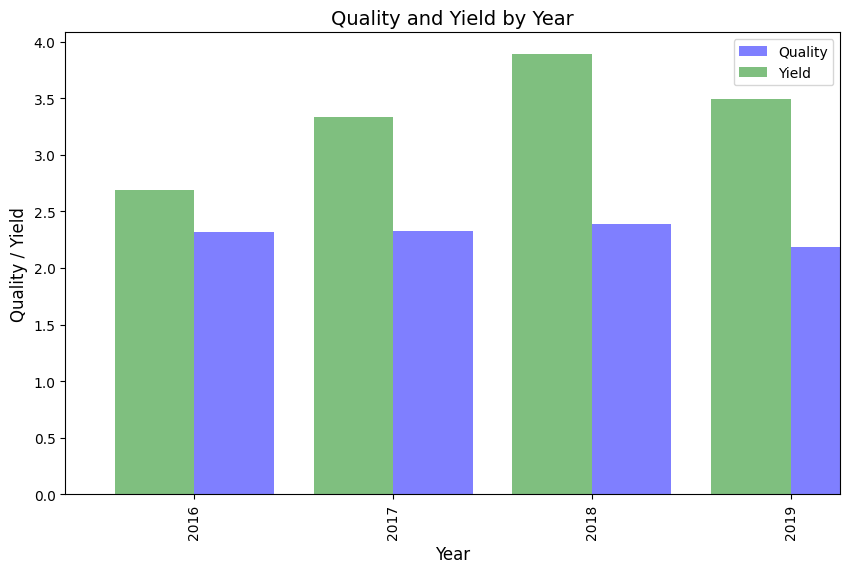

In [261]:
# Load the data
train = pd.read_csv('/content/gdrive/MyDrive/CGIAR_Yield_Estimation_dataset/Train.csv')

# Create a bar plot of Quality and Yield over Year
fig, ax = plt.subplots(figsize=(10, 6))
train.groupby(['Year'])['Quality'].mean().plot(kind='bar', ax=ax, color='blue', alpha=0.5, width=0.4, position=0, label='Quality')
train.groupby(['Year'])['Yield'].mean().plot(kind='bar', ax=ax, color='green', alpha=0.5, width=0.4, position=1, label='Yield')

# Add labels and title
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Quality / Yield', fontsize=12)
ax.set_title('Quality and Yield by Year', fontsize=14)

# Add legend
ax.legend()

# Show the plot
plt.show()



The Heatmap diagram representing the yield prediction by year and field ID 



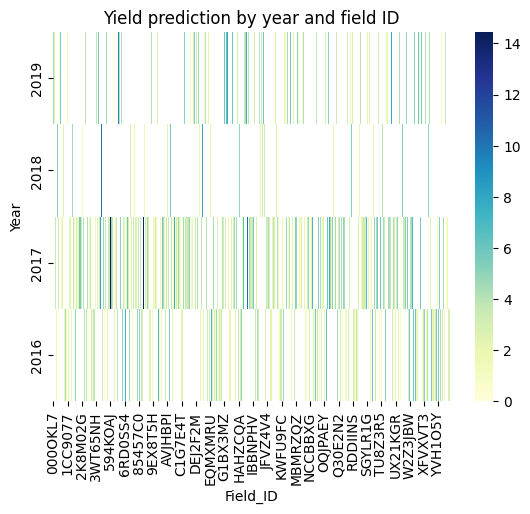

In [262]:
import seaborn as sns
# Load the dataset
df = pd.read_csv('/content/gdrive/MyDrive/CGIAR_Yield_Estimation_dataset/Train.csv')

# Get unique values of 'Year' column
unique_years = df['Year'].unique()

# Create a pivot table to aggregate the data by year and field ID
pivot = pd.pivot_table(data=df, values='Yield', index='Year', columns='Field_ID')
pivot = pivot.loc[unique_years]  # filter out years not in the unique_years list

# Create the heatmap
sns.heatmap(pivot, cmap='YlGnBu')

# Add a title
plt.title('Yield prediction by year and field ID')

# Show the plot
plt.show()


#### Time series diagram of Quality, Yield against time in year.

In [263]:
# Load the data
train = pd.read_csv('/content/gdrive/MyDrive/CGIAR_Yield_Estimation_dataset/Train.csv')
print(train.head())

  Field_ID  Year  Quality  Yield
0  MH2O0YH  2019        3  3.686
1  O9TURWL  2019        2  5.657
2  35AFSDD  2019        3  3.082
3  PM05EG9  2019        2  2.707
4  V7PZBCG  2019        2  2.679


In [264]:
# display shape of our dataset train_sample
new_train_sampled.shape

(2977, 758)

In [265]:
# display shape of our dataset new_train_sample
train_sampled.shape

(2977, 74)

In [266]:
train.columns 

Index(['Field_ID', 'Year', 'Quality', 'Yield'], dtype='object')

In [267]:
train['Year']

0       2019
1       2019
2       2019
3       2019
4       2019
        ... 
2972    2016
2973    2016
2974    2016
2975    2016
2976    2016
Name: Year, Length: 2977, dtype: int64

In [268]:
# add column yield to new_train_sample
new_train_sampled['Yield'] = train['Yield']
new_train_sampled['Year'] = train['Year']

# identify data of Yield column created.
new_train_sampled.columns

Index(['0_S2_B5', '0_S2_B4', '0_S2_B3', '0_S2_B2', '0_CLIM_pr', '0_CLIM_soil',
       '1_S2_B5', '1_S2_B4', '1_S2_B3', '1_S2_B2',
       ...
       'climate_2019_12_ro', 'climate_2019_12_soil', 'climate_2019_12_srad',
       'climate_2019_12_swe', 'climate_2019_12_tmmn', 'climate_2019_12_tmmx',
       'climate_2019_12_vap', 'climate_2019_12_vpd', 'climate_2019_12_vs',
       'Year'],
      dtype='object', length=759)

In [269]:
# Convert "Year" column to datetime format
new_train_sampled['Year'] = pd.to_datetime(new_train_sampled['Year'], format='%Y')

# Extract day, month, and year columns
new_train_sampled['Day'] = new_train_sampled['Year'].dt.day
new_train_sampled['Month'] = new_train_sampled['Year'].dt.month
new_train_sampled['Year'] = new_train_sampled['Year'].dt.year 
new_train_sampled.head()



,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,1_S2_B5,1_S2_B4,1_S2_B3,1_S2_B2,...,climate_2019_12_srad,climate_2019_12_swe,climate_2019_12_tmmn,climate_2019_12_tmmx,climate_2019_12_vap,climate_2019_12_vpd,climate_2019_12_vs,Year,Day,Month
0,934,932,1173,1392,4,287,1015,1036,1397,1516,...,1880.0,0.0,100.0,267.0,1680.0,69.0,210.0,2019,1,1
1,880,821,924,1116,4,287,933,873,1011,1152,...,1883.0,0.0,99.0,273.0,1682.0,75.0,190.0,2019,1,1
2,1016,1070,1357,1632,4,278,1108,1193,1588,1947,...,1875.0,0.0,100.0,274.0,1690.0,76.0,200.0,2019,1,1
3,777,784,639,1064,3,299,832,875,823,1237,...,1898.0,0.0,98.0,263.0,1688.0,64.0,210.0,2019,1,1
4,1081,1122,1162,1487,20,427,1046,1063,1133,1454,...,1930.0,0.0,143.0,291.0,1972.0,87.0,270.0,2019,1,1


In [270]:
new_train_sampled['Date'] = pd.to_datetime(new_train_sampled[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1))
new_train_sampled = new_train_sampled.drop(['Year', 'Month', 'Day'], axis=1)



In [271]:
new_train_sampled.head()
new_train_sampled_df = new_train_sampled
new_train_sampled_df

,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,1_S2_B5,1_S2_B4,1_S2_B3,1_S2_B2,...,climate_2019_12_ro,climate_2019_12_soil,climate_2019_12_srad,climate_2019_12_swe,climate_2019_12_tmmn,climate_2019_12_tmmx,climate_2019_12_vap,climate_2019_12_vpd,climate_2019_12_vs,Date
0,934,932,1173,1392,4,287,1015,1036,1397,1516,...,6.0,215.0,1880.0,0.0,100.0,267.0,1680.0,69.0,210.0,2019-01-01
1,880,821,924,1116,4,287,933,873,1011,1152,...,6.0,215.0,1883.0,0.0,99.0,273.0,1682.0,75.0,190.0,2019-01-01
2,1016,1070,1357,1632,4,278,1108,1193,1588,1947,...,7.0,289.0,1875.0,0.0,100.0,274.0,1690.0,76.0,200.0,2019-01-01
3,777,784,639,1064,3,299,832,875,823,1237,...,6.0,189.0,1898.0,0.0,98.0,263.0,1688.0,64.0,210.0,2019-01-01
4,1081,1122,1162,1487,20,427,1046,1063,1133,1454,...,66.0,1214.0,1930.0,0.0,143.0,291.0,1972.0,87.0,270.0,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972,1060,1216,1291,1586,80,562,1167,1322,1626,1865,...,10.0,914.0,2009.0,0.0,150.0,295.0,1864.0,106.0,280.0,2016-01-01
2973,952,1014,906,1205,73,520,1095,1152,1263,1417,...,9.0,751.0,2016.0,0.0,156.0,298.0,1909.0,109.0,280.0,2016-01-01
2974,894,931,797,1196,79,615,1015,1020,1292,1411,...,10.0,969.0,2005.0,0.0,149.0,295.0,1890.0,103.0,290.0,2016-01-01
2975,917,987,948,1327,38,450,921,992,897,1339,...,8.0,507.0,1892.0,0.0,105.0,277.0,1786.0,72.0,150.0,2016-01-01


In [272]:
new_train_sampled['Yield'] 

0       3.686
1       5.657
2       3.082
3       2.707
4       2.679
        ...  
2972    4.662
2973    3.506
2974    2.619
2975    4.174
2976    3.775
Name: Yield, Length: 2977, dtype: float64

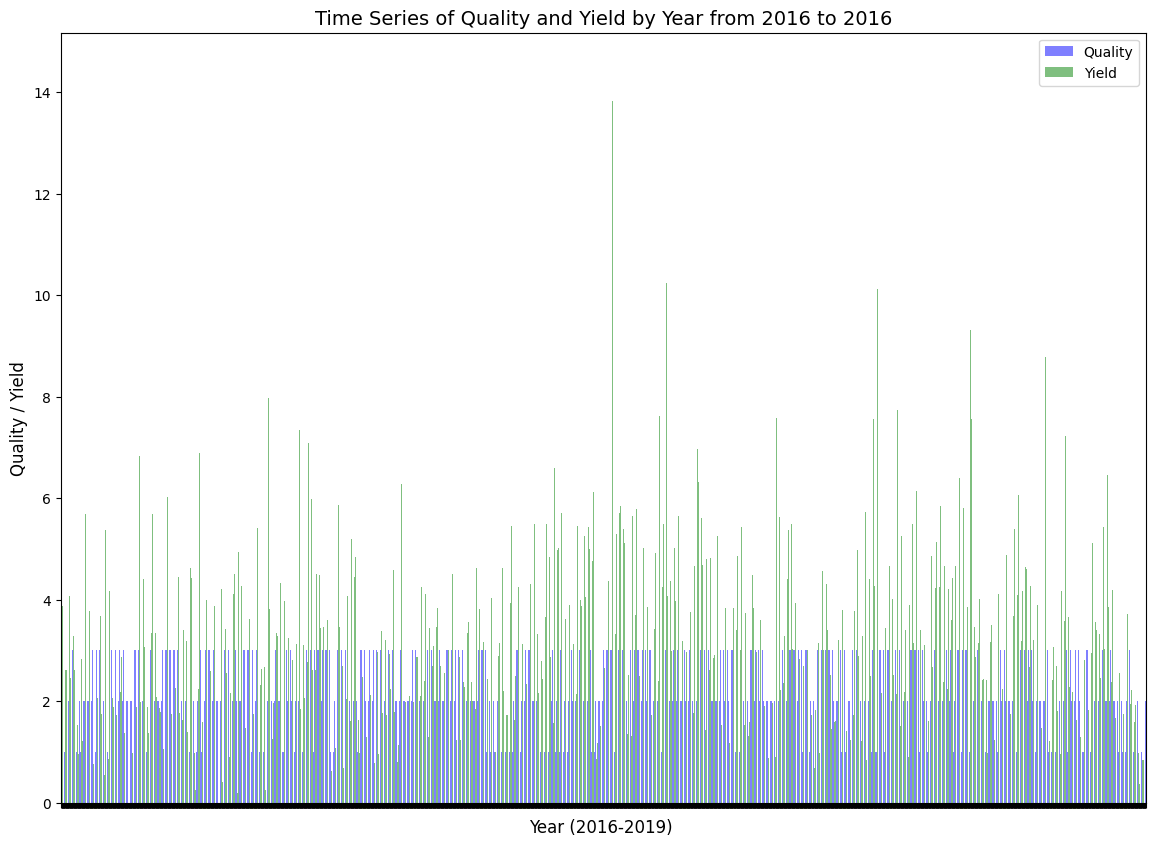

In [273]:
# Load the data
train = pd.read_csv('/content/gdrive/MyDrive/CGIAR_Yield_Estimation_dataset/Train.csv')

# Convert 'Year' column to datetime object
train['Year'] = pd.to_datetime(train['Year'], format='%Y')

# Set 'Year' as index
train = train.set_index('Year')

# Sort the DataFrame by index
train = train.sort_index()

# Create a bar plot of Quality and Yield over Year
fig, ax = plt.subplots(figsize=(14, 10))
train['Quality'].plot(kind='bar', ax=ax, color='blue', alpha=0.5, width=0.4, position=0, label='Quality')
train['Yield'].plot(kind='bar', ax=ax, color='green', alpha=0.5, width=0.4, position=1, label='Yield')

# Add labels and title
ax.set_xlabel('Year (2016-2019) ', fontsize=12)
ax.set_ylabel('Quality / Yield', fontsize=12)
ax.set_title('Time Series of Quality and Yield by Year from 2016 to 2016', fontsize=14)

# Add legend
ax.legend()

# Remove X-axis tick labels
ax.set_xticklabels([])

# Show the plot
plt.show()



 Least Absolute Shrinkage and Selection Operator (LASSO)

In [274]:
new_train_sampled.Field_ID

,Field_ID,Field_ID
0,MH2O0YH,MH2O0YH
1,O9TURWL,O9TURWL
2,35AFSDD,35AFSDD
3,PM05EG9,PM05EG9
4,V7PZBCG,V7PZBCG
...,...,...
2972,FFX8W83,FFX8W83
2973,JAOFQM9,JAOFQM9
2974,Z4D9MU8,Z4D9MU8
2975,SX57GH1,SX57GH1


In [275]:
new_train_sampled.isna().sum()

0_S2_B5                  0
0_S2_B4                  0
0_S2_B3                  0
0_S2_B2                  0
0_CLIM_pr                0
                        ..
climate_2019_12_tmmx    32
climate_2019_12_vap     32
climate_2019_12_vpd     32
climate_2019_12_vs      32
Date                     0
Length: 759, dtype: int64

In [276]:
new_train_sampled.drop('Field_ID', axis=1, inplace=True)

# drop null values 
new_train_sampled.dropna(inplace=True)



Linear Regression Model

In [277]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Drop the 'Date' column before creating the X dataframe
X = new_train_sampled.drop(['Yield', 'Date'], axis=1)
y = new_train_sampled['Yield']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model using the R-squared metric
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = model.score(X_test, y_test)

print('RMSE Score:', rmse)
print('R-squared:', r2)


RMSE Score: 2.760858168469137
R-squared: -1.6116577952984978


Using Lasso Model

In [226]:
# Get all columns in the training data except for 'Yield'
feature_cols = [col for col in train.columns if col != 'Yield']

In [278]:
from sklearn.linear_model import Lasso

# Create a Lasso regression model
lasso_model = Lasso(alpha=0.1)

# Train the model on the training set
lasso_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lasso_model.predict(X_test)

# Evaluate the model using the R-squared metric
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = lasso_model.score(X_test, y_test)

print('RMSE Score:', rmse)
print('R-squared:', r2)


RMSE Score: 1.489659047544994
R-squared: 0.2396705102100286


In [231]:
new_train_sampled.columns

Index(['0_S2_B5', '0_S2_B4', '0_S2_B3', '0_S2_B2', '0_CLIM_pr', '0_CLIM_soil',
       '1_S2_B5', '1_S2_B4', '1_S2_B3', '1_S2_B2',
       ...
       'climate_2019_12_ro', 'climate_2019_12_soil', 'climate_2019_12_srad',
       'climate_2019_12_swe', 'climate_2019_12_tmmn', 'climate_2019_12_tmmx',
       'climate_2019_12_vap', 'climate_2019_12_vpd', 'climate_2019_12_vs',
       'Date'],
      dtype='object', length=757)

### Yield prediction of 2025

In [280]:
new_train_sampled_df

,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,1_S2_B5,1_S2_B4,1_S2_B3,1_S2_B2,...,climate_2019_12_ro,climate_2019_12_soil,climate_2019_12_srad,climate_2019_12_swe,climate_2019_12_tmmn,climate_2019_12_tmmx,climate_2019_12_vap,climate_2019_12_vpd,climate_2019_12_vs,Date
0,934,932,1173,1392,4,287,1015,1036,1397,1516,...,6.0,215.0,1880.0,0.0,100.0,267.0,1680.0,69.0,210.0,2019-01-01
1,880,821,924,1116,4,287,933,873,1011,1152,...,6.0,215.0,1883.0,0.0,99.0,273.0,1682.0,75.0,190.0,2019-01-01
2,1016,1070,1357,1632,4,278,1108,1193,1588,1947,...,7.0,289.0,1875.0,0.0,100.0,274.0,1690.0,76.0,200.0,2019-01-01
3,777,784,639,1064,3,299,832,875,823,1237,...,6.0,189.0,1898.0,0.0,98.0,263.0,1688.0,64.0,210.0,2019-01-01
4,1081,1122,1162,1487,20,427,1046,1063,1133,1454,...,66.0,1214.0,1930.0,0.0,143.0,291.0,1972.0,87.0,270.0,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972,1060,1216,1291,1586,80,562,1167,1322,1626,1865,...,10.0,914.0,2009.0,0.0,150.0,295.0,1864.0,106.0,280.0,2016-01-01
2973,952,1014,906,1205,73,520,1095,1152,1263,1417,...,9.0,751.0,2016.0,0.0,156.0,298.0,1909.0,109.0,280.0,2016-01-01
2974,894,931,797,1196,79,615,1015,1020,1292,1411,...,10.0,969.0,2005.0,0.0,149.0,295.0,1890.0,103.0,290.0,2016-01-01
2975,917,987,948,1327,38,450,921,992,897,1339,...,8.0,507.0,1892.0,0.0,105.0,277.0,1786.0,72.0,150.0,2016-01-01


Column 'Date' not found in the dataset. Make sure the column names are correct.
Column 'Date' not found in the dataset. Make sure the column names are correct.


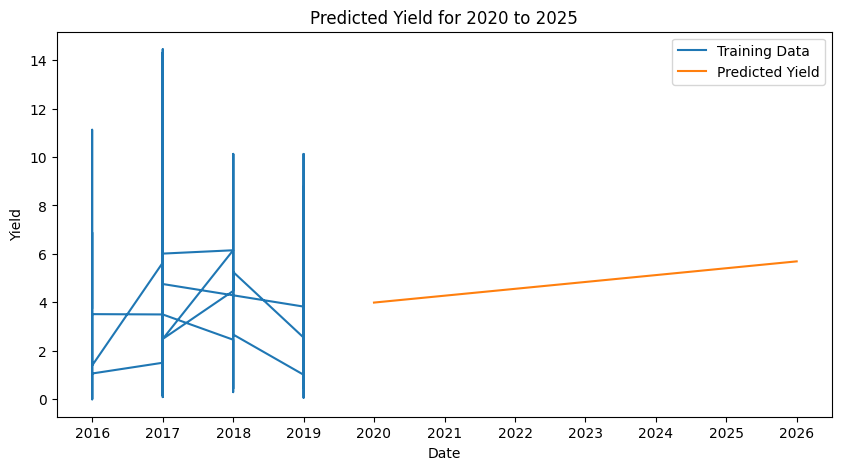

In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load the dataset
try:
    df =new_train_sampled_df
except FileNotFoundError:
    print("File not found. Make sure the file path is correct.")

# Check if the dataset contains a "Date" column
if 'Date' not in df.columns:
    print("Column 'Date' not found in the dataset. Make sure the column names are correct.")

# Convert the "Date" column to datetime and set it as the index
try:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
except KeyError:
    print("Column 'Date' not found in the dataset. Make sure the column names are correct.")

# Create a new dataframe that only includes the data from 2016 to 2019
df_train = df.loc['2016-01-01':'2019-12-31']

# Split the dataset into training and testing sets
X_train = np.array(df_train.index.astype(np.int64) / 10**9).reshape(-1,1)
y_train = df_train['Yield']
X_test = np.array(pd.date_range(start='2020-01-01', end='2025-12-31', freq='D').astype(np.int64) / 10**9, dtype=np.float64).reshape(-1,1)

# Train a linear regression model on the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = model.predict(X_test)

# Convert the predicted yields to a Pandas DataFrame
df_pred = pd.DataFrame(y_pred, index=pd.date_range(start='2020-01-01', end='2025-12-31', freq='D'), columns=['Yield'])

# Visualize the predicted yield for 2020 to 2025
plt.figure(figsize=(10, 5)) # Set the size of the figure to 10x5
plt.plot(df_train.index, y_train, label='Training Data') # Add a label for the training data
plt.plot(df_pred.index, df_pred['Yield'], label='Predicted Yield') # Add a label for the predicted yield
plt.xlabel('Date')
plt.ylabel('Yield')
plt.title('Predicted Yield for 2020 to 2025')
plt.legend() # Add a legend to the plot
plt.show()

